## Descripción del proyecto

Rusty Bargain, una empresa de venta de coches de segunda mano, planea lanzar una aplicación para atraer más clientes. El objetivo de la app es permitir a los usuarios conocer rápidamente el valor de mercado de su coche. Para ello, nos han proporcionado un conjunto de datos que incluye información sobre el historial, especificaciones técnicas, versiones de equipamiento y precios de los vehículos.

El desafío consiste en desarrollar un modelo capaz de predecir el valor de mercado de los coches con los datos proporcionados. Para ello, debemos centrarnos en tres aspectos clave en el desarrollo del modelo: la precisión de las predicciones, la rapidez con que se generen las predicciones y el tiempo necesario para entrenar el modelo.

## 01 Preparación de Datos

Importación de librerías

In [65]:
# Importación de librerías 

import pandas as pd
import matplotlib as plt
import numpy as np 
import re
import math
import time

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from catboost import CatBoostRegressor



Leer archivos

In [66]:
# Leer los datos proporcionado por el cliente 

data = pd.read_csv('./car_data.csv')

Vista general de archivos 

In [67]:
# Verificar la carga de los datos y su estructura

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Preprocesamiento

Formato snake_case

In [68]:
# Convertir nombres de variables a minúsculas y espacios con "_", snake_case

data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in data.columns]

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:


Observaciones: 

Hay variables que no son determinantes para predecir el valor de mercado del auto, haremos un df nuevo que solo contenga aquellas variables importantes para la predicción. 

Eliminar columnas 

In [70]:
# Eliminar columnas con información irrelevante para el modelo 

data_clean = data.drop(['postal_code','last_seen','date_created','date_crawled'], axis = 1)

In [71]:
data_clean.drop(['number_of_pictures'], axis=1, inplace= True) 

In [72]:
# Eliminar la columna, no es relevante para el modelo

data_clean.drop(['registration_month'], axis=1, inplace= True) 

Métricas estadísticas 

In [73]:
# Revisión de métricas estadísticas de nuestros datos 

data_clean.describe()

,price,registration_year,power,mileage
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Observaciones: 

En las métricas estadísticas hay inconsistencia en los datos, valores de 0 en la columna price, en año de registro el máximo es el año 9999 y el mínimo 1000, que nos pueden indicar que ocurrio algun error al registrar los datos. También hay errores similares en las columnas power y registration_month.

Elminar valores inconsistentes

In [74]:
# Contar los valores que tienen años inusuales de registro 

data_clean['registration_year'].value_counts().sort_index()

registration_year
1000    37
1001     1
1039     1
1111     3
1200     1
        ..
9000     3
9229     1
9450     1
9996     1
9999    26
Name: count, Length: 151, dtype: int64

In [75]:
# Filtrar para solo tener los datos de registro despúes de 1900 hasta 2024, que son fechas logicas y reales. 

data_clean = data_clean[(data_clean['registration_year']> 1900) & (data_clean['registration_year']< 2024)]

In [76]:
# Filtrar los datos que tengan power mayor a 0 

data_clean = data_clean[data_clean['power']>0]

In [77]:
# Filtrar los datos que tengan price mayor a 0 

data_clean = data_clean[data_clean['price']>0]

In [78]:
# Resetear el índice después de eliminar filas

data_clean.reset_index(inplace = True)

Celdas sin información (NaN)

In [79]:
# Revisar valores ausentes 

data_clean.isna().sum()

index                    0
price                    0
vehicle_type         21362
registration_year        0
gearbox               6087
power                    0
model                12480
mileage                  0
fuel_type            19809
brand                    0
not_repaired         47167
dtype: int64

Observaciones: 

Las variables que presentan valores ausentes son categóricas, podríamos sustituir isna por 'desconocido'. Eliminar isna y no tener complicaciones más adelante. 

In [80]:
# Rellenar valores isna con 'desconocido' 

data_clean.fillna('desconocido', inplace= True)

In [81]:
# Comprobar que no hay valores ausentes 

data_clean.isna().sum()

index                0
price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
mileage              0
fuel_type            0
brand                0
not_repaired         0
dtype: int64

Duplicados

In [82]:
# Revisar valores duplicados 

data_clean.duplicated().sum() 

0

In [83]:
data_clean.describe()

,index,price,registration_year,power,mileage
count,307199.000000,307199.000000,307199.000000,307199.000000,307199.000000
mean,177238.611805,4809.842014,2003.298894,124.081133,128417.263728
std,102216.565325,4586.439372,6.955098,194.503362,36748.417792
min,1.000000,1.000000,1910.000000,1.000000,5000.000000
25%,88784.500000,1300.000000,1999.000000,75.000000,125000.000000
50%,177204.000000,3100.000000,2003.000000,110.000000,150000.000000
75%,265742.000000,6950.000000,2008.000000,150.000000,150000.000000
max,354368.000000,20000.000000,2019.000000,20000.000000,150000.000000


In [84]:
# Separar características categóricas 

caracteristicas_categoricas = list(data_clean.dtypes[data_clean.dtypes == 'object'].index)

In [85]:
# Contar los valores de cada variable categórica

for caracteristica in caracteristicas_categoricas:
    print(data_clean[caracteristica].value_counts())
    print()
    print()

vehicle_type
sedan          83172
small          70184
wagon          59342
bus            26243
desconocido    21362
convertible    18785
coupe          14634
suv            10971
other           2506
Name: count, dtype: int64


gearbox
manual         240681
auto            60431
desconocido      6087
Name: count, dtype: int64


model
golf                  26020
other                 20825
3er                   17794
desconocido           12480
polo                  11157
                      ...  
i3                        5
samara                    5
rangerover                3
serie_3                   3
range_rover_evoque        2
Name: count, Length: 250, dtype: int64


fuel_type
petrol         192132
gasoline        89580
desconocido     19809
lpg              4798
cng               501
hybrid            205
other              97
electric           77
Name: count, dtype: int64


brand
volkswagen        67019
opel              33964
bmw               33127
mercedes_benz     280

Observaciones: 

Hay variables categóricas que son ordinales y otras nominales. Esto se debe a que 'brand' y 'model', influyen en el precio del coche,tendríamos que codificarlas con posicionamiento en el mercado (variables ordinales).   

Conversión de variables 

In [86]:
# Convertir variables ordinales

data_clean[['brand', 'model']] = OrdinalEncoder().fit_transform(data_clean[['brand', 'model']])

Codificación OHE 

In [87]:
# Codificar variables nominales que faltan del data_clean 

data_clean_encoded = pd.get_dummies(data_clean, drop_first=True)

In [88]:
data_clean_encoded

,index,price,registration_year,power,model,mileage,brand,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_desconocido,...,gearbox_manual,fuel_type_desconocido,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,not_repaired_no,not_repaired_yes
0,1,18300,2011,190,91.0,125000,1.0,False,True,False,...,True,False,False,True,False,False,False,False,False,True
1,2,9800,2004,163,118.0,125000,14.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,3,1500,2001,75,117.0,150000,38.0,False,False,False,...,True,False,False,False,False,False,False,True,True,False
3,4,3600,2008,69,102.0,90000,31.0,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4,5,650,1995,102,11.0,150000,2.0,False,False,False,...,True,False,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307194,354361,5250,2016,150,4.0,150000,0.0,False,False,True,...,False,True,False,False,False,False,False,False,True,False
307195,354362,3200,2004,225,141.0,150000,30.0,False,False,False,...,True,False,False,False,False,False,False,True,False,True
307196,354366,1199,2000,101,107.0,125000,32.0,True,False,False,...,False,False,False,False,False,False,False,True,True,False
307197,354367,9200,1996,102,224.0,150000,38.0,False,False,False,...,True,False,False,True,False,False,False,False,True,False


## 02 Modelos

In [89]:
# Separar df para modelo 

train_valid, test = train_test_split(data_clean_encoded, test_size = 0.2, random_state=12345)

In [90]:
# Entranamiento y validación 

train, valid = train_test_split(train_valid, test_size=0.25, random_state=56789)

In [91]:
# Función para calcular el RMSE de cada tipo de modelo

def rmse(prediccion,valor_real):
    return math.sqrt(mean_squared_error(prediccion, valor_real))

In [92]:
# Borrar columna 'price' del conjunto de entrenamiento, validación y prueba, es la variable objetivo a predecir 

caracteristicas_entrenamiento = train.drop(['price'], axis=1)
caracteristicas_validacion = valid.drop(['price'], axis=1)
caracteristicas_prueba = test.drop(['price'], axis=1)

In [93]:
# Guardando la culumna 'price' 

meta_entrenamiento = train['price']
meta_valid = valid['price']
meta_test = test['price']

#### 01 Regresión Líneal 

In [141]:
# Calculadora de tiempo de ejecución de cada modelo

start_regresion_lineal = time.time()

In [142]:
# Modelo de regresión líneal 

model_regresion_lineal = LinearRegression()

In [143]:
# Entrenar cada modelo con su objetivo correspondiente

model_regresion_lineal.fit(caracteristicas_entrenamiento,meta_entrenamiento)



LinearRegression()

In [144]:

# Predicciones sobre cada conjunto de datos

pred_train_lregresion = model_regresion_lineal.predict(caracteristicas_entrenamiento)
pred_valid_lregresion = model_regresion_lineal.predict(caracteristicas_validacion)
pred_test_lregresion = model_regresion_lineal.predict(caracteristicas_prueba)

In [145]:
print('Entrenamiento Regresion Lineal - RMSE:', rmse(meta_entrenamiento,pred_train_lregresion))
print('Validacion Regresion Lineal - RMSE:', rmse(meta_valid,pred_valid_lregresion))
print('Prueba Regresion Lineal - RMSE:',rmse(meta_test,pred_test_lregresion))

Entrenamiento Regresion Lineal - RMSE: 3197.565471189471
Validacion Regresion Lineal - RMSE: 3181.527471750991
Prueba Regresion Lineal - RMSE: 3208.9945932590217


In [146]:
# Guardar resultados en un dataframe

resultados_lr = pd.DataFrame({
    'Modelo': ['Regresion Lineal'],
    'Entrenamiento': [rmse(meta_entrenamiento,pred_train_lregresion)],
    'Validacion': [rmse(meta_valid,pred_valid_lregresion)],
    'Prueba': [rmse(meta_test,pred_test_lregresion)]
})

In [147]:
# Calculadora de tiempo final

time.sleep(1)
end_regresion_lineal = time.time()

print(f"Tiempo de ejecución Regresion Lineal: {end_regresion_lineal - start_regresion_lineal:.4f} segundos")

tiempo_rl = end_regresion_lineal - start_regresion_lineal

Tiempo de ejecución Regresion Lineal: 12.3794 segundos


Observciones: 

Los valores de RMSE son altos respecto al valor promedio de los coches de nuestro dataset, si tomamos en cuenta que los valores de RMSE tiene como unidad euros. Por otro lado, los valores se mantuvieron estables entre los datos de entrenamiento y los de prueba.

#### 02 Random Forest

In [148]:
# Calculadora de tiempo de ejecución de cada modelo
 
start_random_forest = time.time()

In [149]:
# Modelo de Random Forest 
 
model_random_forest = RandomForestRegressor(max_depth=23,
    max_features='sqrt',
    min_samples_leaf=5,
    min_samples_split=2,
    n_estimators=100,
    random_state=42)


In [150]:
# Entrenar modelo 

model_random_forest.fit(caracteristicas_entrenamiento,meta_entrenamiento)

RandomForestRegressor(max_depth=23, max_features='sqrt', min_samples_leaf=5,
                      random_state=42)

In [151]:
# Predicciones sobre cada conjunto de datos

pred_train_rfregressor = model_random_forest.predict(caracteristicas_entrenamiento)
pred_valid_rfregressor = model_random_forest.predict(caracteristicas_validacion)
pred_test_rfregressor = model_random_forest.predict(caracteristicas_prueba)

In [152]:
print('Entrenamiento Random Forest - RMSE:', rmse(meta_entrenamiento,pred_train_rfregressor))
print('Validacion Random Forest - RMSE:', rmse(meta_valid,pred_valid_rfregressor))
print('Prueba Random Forest - RMSE:',rmse(meta_test,pred_test_rfregressor))

Entrenamiento Random Forest - RMSE: 1516.5885120480061
Validacion Random Forest - RMSE: 1683.8878568671748
Prueba Random Forest - RMSE: 1723.3216069754887


In [153]:
# Guardar resultados en un dataframe

resultados_randomf = pd.DataFrame({
    'Modelo': ['Regresion Lineal'],
    'Entrenamiento': [rmse(meta_entrenamiento,pred_train_rfregressor)],
    'Validacion': [rmse(meta_valid,pred_valid_rfregressor)],
    'Prueba': [rmse(meta_test,pred_test_rfregressor)]
})

In [154]:
# Calculadora de tiempo final

time.sleep(1)
end_random_forest = time.time()

print(f"Tiempo de ejecución Random Forest: {end_random_forest - start_random_forest:.4f} segundos")

tiempo_rf = end_random_forest - start_random_forest

Tiempo de ejecución Random Forest: 50.3580 segundos


Observaciones: 

Al probar con el modelo de Random Forest, el valor de RMSE se redujo casi a la mitad a comparación con la Regresión Lineal. Los valores de entrenamiento y prueba del Random Forest presentan una ligera diferencia, el modelo generaliza adecuadamente. En tiempo de ejecución evidentemente, RF tardó prácticamente el doble, por la complejidad de cálculos que realiza.  
 

#### 03 LightGBM

In [155]:
# Calculadora de tiempo de ejecución de cada modelo

start_lgmb = time.time()

In [156]:
# Modelo LightGBM  

model_lgbm = lgb.LGBMRegressor(
    n_estimators=500, 
    learning_rate=0.1,
    max_depth=8,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42
)

model_lgbm.fit(
    caracteristicas_entrenamiento,
    meta_entrenamiento,
    eval_set = [(caracteristicas_validacion, meta_valid)]    
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 184319, number of used features: 25
[LightGBM] [Info] Start training from score 4801.739582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(colsample_bytree=0.8, max_depth=8, n_estimators=500,
              random_state=42, reg_alpha=1.0, reg_lambda=1.0, subsample=0.8)

In [157]:
# Predicciones sobre cada conjunto de datos

pred_train = model_lgbm.predict(caracteristicas_entrenamiento)
pred_valid = model_lgbm.predict(caracteristicas_validacion)
pred_test = model_lgbm.predict(caracteristicas_prueba)

In [158]:
print('Entrenamiento LightGBM - RMSE:', rmse(meta_entrenamiento,pred_train))
print('Validacion LightGBM - RMSE:', rmse(meta_valid,pred_valid))
print('Prueba LightGBM - RMSE:',rmse(meta_test,pred_test))

Entrenamiento LightGBM - RMSE: 1510.8774001313966
Validacion LightGBM - RMSE: 1591.2440006442937
Prueba LightGBM - RMSE: 1629.5628909435673


In [159]:
# Guardar resultados en un dataframe

resultados_lgbm = pd.DataFrame({
    'Modelo': ['Regresion Lineal'],
    'Entrenamiento': [rmse(meta_entrenamiento,pred_train)],
    'Validacion': [rmse(meta_valid,pred_valid)],
    'Prueba': [rmse(meta_test,pred_test)]
})

In [160]:
# Calculadora de tiempo final

time.sleep(1)
end_lgbm = time.time()

print(f"Tiempo de ejecución LightGBM: {end_lgbm - start_lgmb:.4f} segundos")

tiempo_lightGBM = end_lgbm - start_lgmb

Tiempo de ejecución LightGBM: 18.4283 segundos


Observaciones: 

En la prueba con el modelo LightGBM logró reducir el RMSE que nos había dado el modelo RF de 1723 euros a 1629, con una reducción de tiempo de 18 segundos al ejecutar el modelo. Esto representa una mejora significativa tanto en precisión como en eficiencia computacional.

#### 04 CatBoost

In [161]:
# Calculadora de tiempo de ejecución de cada modelo

start_cat_boost = time.time()

In [162]:
# Modelo CatBoost

model_cat_boost = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,      # bajamos la tasa para más precisión
    depth=8,                 # árboles más profundos
    l2_leaf_reg=3,           # regularización
    random_strength=1,
    bagging_temperature=1,
    early_stopping_rounds=50,
    verbose=100,
    random_state=42
)

In [163]:
# Entrenar modelo 

model_cat_boost.fit(caracteristicas_entrenamiento,
    meta_entrenamiento,
    eval_set = (caracteristicas_validacion,meta_valid))

0:	learn: 4428.1323466	test: 4421.2513784	best: 4421.2513784 (0)	total: 33.7ms	remaining: 33.7s
100:	learn: 1863.6665868	test: 1848.5504169	best: 1848.5504169 (100)	total: 3.31s	remaining: 29.4s
200:	learn: 1749.2417474	test: 1743.3303505	best: 1743.3303505 (200)	total: 6.25s	remaining: 24.8s
300:	learn: 1695.7666961	test: 1698.0881697	best: 1698.0881697 (300)	total: 9.14s	remaining: 21.2s
400:	learn: 1659.6643197	test: 1670.8754652	best: 1670.8754652 (400)	total: 11.6s	remaining: 17.4s
500:	learn: 1629.6456339	test: 1649.9676640	best: 1649.9676640 (500)	total: 14s	remaining: 13.9s
600:	learn: 1608.2766004	test: 1636.3545650	best: 1636.3545650 (600)	total: 16.4s	remaining: 10.9s
700:	learn: 1589.1425190	test: 1625.6460855	best: 1625.6460855 (700)	total: 18.6s	remaining: 7.95s
800:	learn: 1571.9619692	test: 1617.0045793	best: 1617.0045793 (800)	total: 21s	remaining: 5.23s
900:	learn: 1557.0605523	test: 1610.7515600	best: 1610.7515600 (900)	total: 23.3s	remaining: 2.56s
999:	learn: 1543.

In [164]:
# Predicciones sobre cada conjunto de datos

pred_train_catboost = model_cat_boost.predict(caracteristicas_entrenamiento)
pred_valid_catboost = model_cat_boost.predict(caracteristicas_validacion)
pred_test_catboost = model_cat_boost.predict(caracteristicas_prueba)

In [165]:
# RMSE para cada conjunto
rmse_train = rmse(meta_entrenamiento, pred_train_catboost)
rmse_valid = rmse(meta_valid, pred_valid_catboost)
rmse_test = rmse(meta_test, pred_test_catboost)

# Mostrar resultados
print(f"Entrenamiento Catboost - RMSE: {rmse_train:.2f}")
print(f"Validación  Catboost  - RMSE: {rmse_valid:.2f}")
print(f"Prueba  CatBoost      - RMSE: {rmse_test:.2f}")

Entrenamiento Catboost - RMSE: 1543.04
Validación  Catboost  - RMSE: 1604.54
Prueba  CatBoost      - RMSE: 1639.76


In [166]:
# Guardar resultados en un dataframe

resultados_catboost = pd.DataFrame({
    'Modelo': ['Regresion Lineal'],
    'Entrenamiento': [rmse(meta_entrenamiento, pred_train_catboost)],
    'Validacion': [rmse(meta_valid, pred_valid_catboost)],
    'Prueba': [rmse(meta_test, pred_test_catboost)]
})

In [167]:
# Calculadora de tiempo final

time.sleep(1)
end_cat_boost = time.time()

print(f"Tiempo de ejecución CatBoost : {end_cat_boost - start_cat_boost:.4f} segundos")

tiempo_catboost = end_cat_boost - start_cat_boost

Tiempo de ejecución CatBoost : 40.9585 segundos


Observaciones:

Al probar con el modelo CatBoost, descubrimos que a pesar de su ventaja para analizar variables categóricas, no fue tan útil, porque ya habíamos codificado nuestras variables antes de entrenar los distintos tipos de modelos. La variación de resultados de RMSE es baja, pero tarda el doble de tiempo que el modelo LightGBM. 

### Comparativa de modelos 

In [ ]:
# Guardar en un df todos los resultados de los modelos y los tiempos de ejecución

resultados_modelos = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Random Forest', 'LightGBM', 'CatBoost'],
    'RMSE_Entrenamiento': [
        resultados_lr['Entrenamiento'].iloc[0],
        resultados_randomf['Entrenamiento'].iloc[0],
        resultados_lgbm['Entrenamiento'].iloc[0],
        resultados_catboost['Entrenamiento'].iloc[0]
    ],
    'RMSE_Validación': [
        resultados_lr['Validacion'].iloc[0],
        resultados_randomf['Validacion'].iloc[0],
        resultados_lgbm['Validacion'].iloc[0],
        resultados_catboost['Validacion'].iloc[0]
    ],
    'RMSE_Prueba': [
        resultados_lr['Prueba'].iloc[0],
        resultados_randomf['Prueba'].iloc[0],
        resultados_lgbm['Prueba'].iloc[0],
        resultados_catboost['Prueba'].iloc[0]
    ],
    'Tiempo_Ejecución': [
        tiempo_rl,
        tiempo_rf,
        tiempo_lightGBM,
        tiempo_catboost
    ]
})

# Redondear tiempo de ejecución a 2 decimales
resultados_modelos['Tiempo_Ejecución'] = resultados_modelos['Tiempo_Ejecución'].round(2)

In [ ]:
# Dataframe final con resultados de los modelos y tiempos de ejecución
resultados_modelos

,Modelo,RMSE_Entrenamiento,RMSE_Validación,RMSE_Prueba,Tiempo_Ejecución
0,Regresión Lineal,3197.565471,3181.527472,3208.994593,12.38
1,Random Forest,1516.588512,1683.887857,1723.321607,50.36
2,LightGBM,1510.877400,1591.244001,1629.562891,18.43
3,CatBoost,1543.037389,1604.542020,1639.764860,40.96


Gráficos comparativos

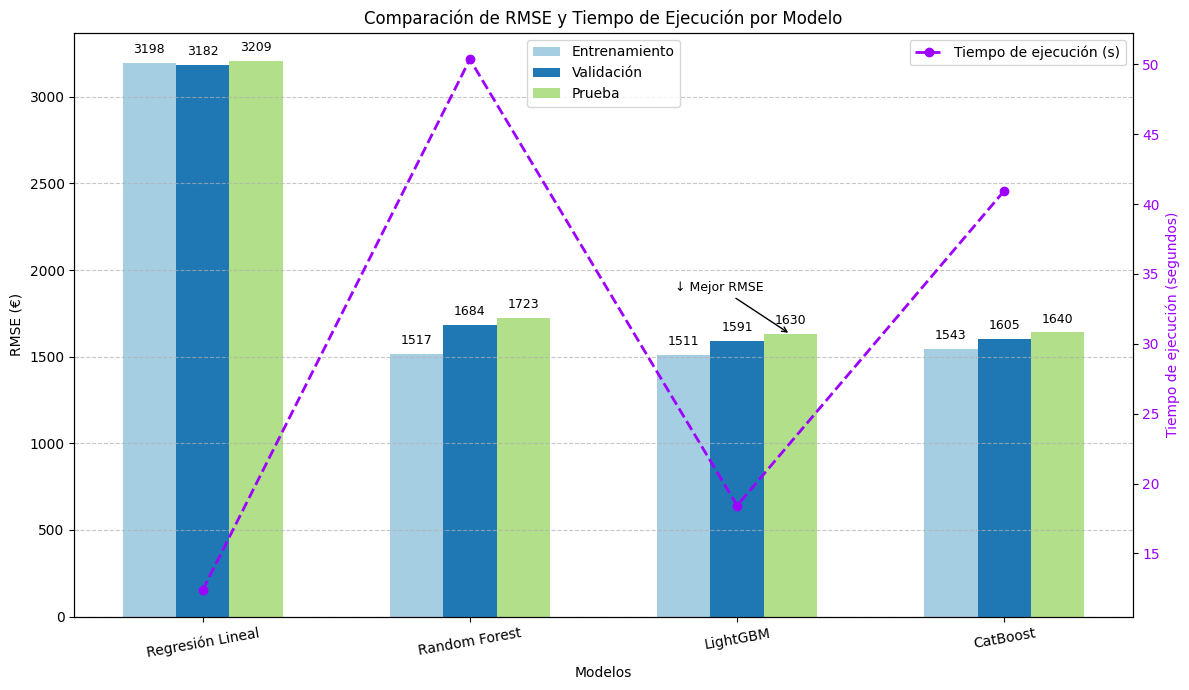

In [ ]:
# Extraer datos del DataFrame
model_names = resultados_modelos['Modelo'].tolist()
rmse_train = resultados_modelos['RMSE_Entrenamiento'].tolist()
rmse_valid = resultados_modelos['RMSE_Validación'].tolist()
rmse_test = resultados_modelos['RMSE_Prueba'].tolist()
execution_time = resultados_modelos['Tiempo_Ejecución'].tolist()

# Gráfico
fig, ax1 = plt.subplots(figsize=(12, 7))
bar_width = 0.2
index = np.arange(len(model_names))

colors = ['#A6CEE3', '#1F78B4', '#B2DF8A']

# Barras RMSE
rects1 = ax1.bar(index - bar_width, rmse_train, bar_width, label='Entrenamiento', color=colors[0])
rects2 = ax1.bar(index, rmse_valid, bar_width, label='Validación', color=colors[1])
rects3 = ax1.bar(index + bar_width, rmse_test, bar_width, label='Prueba', color=colors[2])

ax1.set_xlabel('Modelos')
ax1.set_ylabel('RMSE (€)')
ax1.set_title('Comparación de RMSE y Tiempo de Ejecución por Modelo')
ax1.set_xticks(index)
ax1.set_xticklabels(model_names, rotation=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper center')

def add_labels(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + 40,
                f'{height:.0f}', ha='center', va='bottom', fontsize=9)

add_labels(rects1, ax1)
add_labels(rects2, ax1)
add_labels(rects3, ax1)

# Línea de tiempo de ejecución
ax2 = ax1.twinx()
ax2.plot(index, execution_time, color="#9D00FF", marker='o', linestyle='--', label='Tiempo de ejecución (s)', linewidth=2)
ax2.set_ylabel('Tiempo de ejecución (segundos)', color='#9D00FF')
ax2.tick_params(axis='y', labelcolor='#9D00FF')
ax2.legend(loc='upper right')

# Mejor RMSE en conjunto de prueba
best_model_idx = np.argmin(rmse_test)
ax1.annotate('↓ Mejor RMSE',
             xy=(best_model_idx + bar_width, rmse_test[best_model_idx]),
             xytext=(best_model_idx + 0.1, rmse_test[best_model_idx] + 250),  
             arrowprops=dict(
                 facecolor='gray', 
                 arrowstyle='->',     
                 lw=1,                
             ),
             fontsize=9, ha='right', color='black')

fig.tight_layout()
plt.show()

## 03 Conclusiones


La prestadora de servicios de venta de coches de segunda mano Rusty Bargain quiere lanzar una app para atraer a más clientes, con la premisa de permitirles averiguar rápidamente el valor de mercado de su coche. Se nos brindó un dataset con información sobre el historial, especificaciones técnicas, versiones de equipamiento y precios. Nuestro objetivo es crear un modelo que determine el valor de mercado de los coches a partir de la información proporcionada. Las tres directrices a seguir para el desarrollo del modelo son: la calidad de la predicción, la velocidad de la predicción y el tiempo requerido para el entrenamiento.

Durante la etapa de diagnóstico, descartamos las variables que no contribuían significativamente a la predicción. Encontramos que gran parte de los datos presentaban valores inconsistentes, irregulares o faltantes. Por ello, eliminamos aquellas filas con datos que podían desequilibrar el modelo, especialmente en las columnas 'price', 'power' y 'registration_year'.

Identificamos las variables categóricas y numéricas para realizar una codificación adecuada. Algunas variables categóricas eran ordinales, mientras que otras eran nominales, lo cual indicaba que debíamos codificarlas de forma distinta. Para 'brand' y 'model', utilizamos OrdinalEncoder, ya que dichas variables tienen un peso o valor específico en el mercado automotriz. El resto de las variables categóricas fueron codificadas mediante get_dummies (0, 1).

Para el desarrollo del modelo predictivo, probamos distintos algoritmos y métodos de potenciación del gradiente con el fin de identificar el que mejor cumpliera con nuestras directrices. Evaluamos Linear Regression, Random Forest, LightGBM y CatBoost. Este benchmark reveló que LightGBM fue el modelo con mejor desempeño en este caso.

El modelo LightGBM optimizado logró reducir el RMSE en el conjunto de prueba de aproximadamente 1723 € RF a 1629 €, mientras que el tiempo de entrenamiento disminuyó a 18 segundos. Esto representa una mejora significativa tanto en precisión como en eficiencia computacional, lo que lo convierte en un candidato ideal para aplicaciones prácticas.

A pesar de que CatBoost obtuvo métricas de RMSE muy cercanas a las de LightGBM, su tiempo de ejecución fue el doble. Es posible que, al utilizar un dataset con más variables categóricas, CatBoost podría obtener mejores resultados.





